In [12]:
import sys
sys.path.append('../../astro_tools')
sys.path.append('../')
import axes_offset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from tqdm import tqdm
from astropy.wcs import wcs
from matplotlib.offsetbox import AnchoredText
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import ImageGrid
from reproject import reproject_interp
from astropy import units as u
from matplotlib.lines import Line2D
from astropy.convolution import convolve, Box2DKernel
# from astropy.visualization.wcsaxes import add_beam, add_scalebar


# set up the plot
import cmasher as cmr
plt.rcParams['text.usetex'] = False
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.5
plt.rcParams["axes.labelweight"] = 'bold'
plt.rcParams["axes.titleweight"] = 'bold'
plt.rcParams["font.family"] = "courier new"
plt.rcParams["font.style"] = "normal"
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["font.weight"] = 'bold'

# anchored text font
Afont = {
        'family' : 'courier new',
        'color':  'white',
        'size': 22,
        }

Afont_labels = {
        'family' : 'courier new',
        'color':  'white',
        'size': 15,
        }

Afont_labels1 = {
        'family' : 'courier new',
        'color':  'black',
        'size': 15,
        }

import warnings
warnings.filterwarnings('ignore')

In [6]:
def line_flux(amp, sig):
    
    """
    
    Adopted from https://lukeholden.com/blog/measuring_emission_line_fluxes_python.html#measuring_line_fluxes
    
    """
    
    sig_Ang = (sig * 2.2) / 100
    
    flux = amp * sig_Ang * np.sqrt(2*np.pi)
#     flux_err = flux*np.sqrt((peak_err/peak)**2 + (width_err/width)**2)
    return flux


def get_data(line,param,comp):
    
    """
    line must be ha, niia, niib, siia, or siib
    param must be amp, vel, or sigma
    comp must be outflow_blue, outflow_red, or disk
    
    """
    
    file = '../../ngc253/muse/data/output_maps/ngc253_muse_se_%s_%s_%s.fits' % (line, param, comp)
    
    hdu = fits.open(file)
    hdu_data = hdu[0].data
    
    return(hdu_data)


def make_big_plot(axNums, outb_dat, outr_dat, disk_dat, vmin, vmax, 
                  titles, line_label, cbar_label, extent, cmap, cmap_extend,
                  alpha_outb='None', alpha_outr='None', alpha_disk='None'):
        
    cmap_alpha = cmr.get_sub_cmap('gist_gray_r', 0.0, 0.5)
    
    # BLUESHIFTED OUTFLOW
    im = axNums[0].imshow(outb_dat, origin='lower', cmap=cmap,vmin=vmin,vmax=vmax,extent=extent)
    
    # do we want to blank out any pixels?
    if type(alpha_outb) != str:
        print('yes')
        gray_outb = np.zeros_like(outb_dat)
        gray_outb[~np.isfinite(outb_dat)] = np.nan
        axNums[0].imshow(gray_outb, origin='lower',cmap=cmap_alpha, alpha=alpha_outb,extent=extent)
    
    axNums[0].tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=20, length=5, color='white')
    axNums[0].set_facecolor('black')
    axNums[0].set_yticks([-40, -20, 0, 20, 40])
    
    # add label that this is the SE side of the outflow
    at = AnchoredText('SE', prop=Afont, frameon=False, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    axNums[0].add_artist(at)
    
    # optional label for which line we are looking at
    if line_label != None:
        at = AnchoredText(line_label, prop=Afont, frameon=False, loc='lower left')
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        axNums[0].add_artist(at)
      
    # add a title to the subplot
    if titles == True:
        axNums[0].set_title('Outflow B', fontsize=26)

    # REDSHIFTED OUTFLOW
    im = axNums[1].imshow(outr_dat, origin='lower', cmap=cmap,vmin=vmin,vmax=vmax,extent=extent)
    
    # do we want to blank out any pixels?
    if type(alpha_outr) != str:
        gray_outr = np.zeros_like(outr_dat)
        gray_outr[~np.isfinite(outr_dat)] = np.nan
        axNums[1].imshow(gray_outr, origin='lower',cmap=cmap_alpha, alpha=alpha_outr,extent=extent)
    
    axNums[1].tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=20, length=5, color='white')
    axNums[1].set_facecolor('black')
    
    # add label that this is the SE side of the outflow
    at = AnchoredText('SE', prop=Afont, frameon=False, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    axNums[1].add_artist(at)
    
    # optional label for which line we are looking at
    if line_label != None:
        at = AnchoredText(line_label, prop=Afont, frameon=False, loc='lower left')
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        axNums[1].add_artist(at)
        
    if titles == True:
        axNums[1].set_title('Outflow R', fontsize=26)

    # DISK
    im = axNums[2].imshow(disk_dat, origin='lower', cmap=cmap,vmin=vmin,vmax=vmax,extent=extent)
    
    # do we want to blank out any pixels?
    if type(alpha_disk) != str:
        gray_disk = np.zeros_like(disk_dat)
        gray_disk[~np.isfinite(disk_dat)] = np.nan
        axNums[2].imshow(gray_disk, origin='lower',cmap=cmap_alpha, alpha=alpha_disk,extent=extent)
    
    axNums[2].tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=20, length=5, color='white')
    axNums[2].set_facecolor('black')
    
    # add label that this is the SE side of the outflow
    at = AnchoredText('SE', prop=Afont, frameon=False, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    axNums[2].add_artist(at)
    
    # optional label for which line we are looking at
    if line_label != None:
        at = AnchoredText(line_label, prop=Afont, frameon=False, loc='lower left')
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        axNums[2].add_artist(at)
        
    if titles == True:
        axNums[2].set_title('Disk', fontsize=26)

    cax = axNums[2].inset_axes([1.04, 0.002, 0.05, 1])  # make another axis for the colorbar 
                                                 # [x0, y0, width, height] where x0, y0 = lower left corner
    bar = fig.colorbar(im, ax=axNums[2], cax=cax, extend=cmap_extend)
    bar.set_label(cbar_label, fontsize=20)
    bar.ax.tick_params(width=2.5, labelsize=18, length=7, direction='in')
    
    return


In [8]:
og = '../../ngc253/muse/data/ADP.2018-11-22T21_29_46.157.fits'
hdu = fits.open(og)[1]
og_data = hdu.data
w = wcs.WCS(hdu.header, naxis=2).celestial


ra_hms, dec_dms = axes_offset.get_offset(og_data, w)
extent = axes_offset.get_extent(dat=og_data, x_dim=2, y_dim=1, pixscale=0.2)

<SkyCoord (ICRS): (ra, dec) in deg
    (11.89324129, -25.19976396)>


### Deciding upon T = 6500 K

In [9]:
# get siib, siia amplitudes and sigmas
siib_amp_disk = get_data(line='siib', param='amp', comp='disk')
siib_amp_outb = get_data(line='siib', param='amp', comp='outflow_blue')
siib_amp_outr = get_data(line='siib', param='amp', comp='outflow_red')
siia_amp_disk = get_data(line='siia', param='amp', comp='disk')
siia_amp_outb = get_data(line='siia', param='amp', comp='outflow_blue')
siia_amp_outr = get_data(line='siia', param='amp', comp='outflow_red')

siib_sig_disk = get_data(line='siib', param='sig', comp='disk')
siib_sig_outb = get_data(line='siib', param='sig', comp='outflow_blue')
siib_sig_outr = get_data(line='siib', param='sig', comp='outflow_red')
siia_sig_disk = get_data(line='siia', param='sig', comp='disk')
siia_sig_outb = get_data(line='siia', param='sig', comp='outflow_blue')
siia_sig_outr = get_data(line='siia', param='sig', comp='outflow_red')

# convert to flux
siia_flux_disk = line_flux(siia_amp_disk, siia_sig_disk)
siia_flux_outb = line_flux(siia_amp_outb, siia_sig_outb)
siia_flux_outr = line_flux(siia_amp_outr, siia_sig_outr)
siib_flux_disk = line_flux(siib_amp_disk, siib_sig_disk)
siib_flux_outb = line_flux(siib_amp_outb, siib_sig_outb)
siib_flux_outr = line_flux(siib_amp_outr, siib_sig_outr)

# take ratios
# sii_disk_flux_rat = siia_flux_disk / siib_flux_disk
# sii_outb_flux_rat = siia_flux_outb / siib_flux_outb
# sii_outr_flux_rat = siia_flux_outr / siib_flux_outr

# create upper limit of 1.4
# sii_disk_flux_rat[sii_disk_flux_rat > 1.4] = 1.4
# sii_outb_flux_rat[sii_outb_flux_rat > 1.4] = 1.4
# sii_outr_flux_rat[sii_outr_flux_rat > 1.4] = 1.4

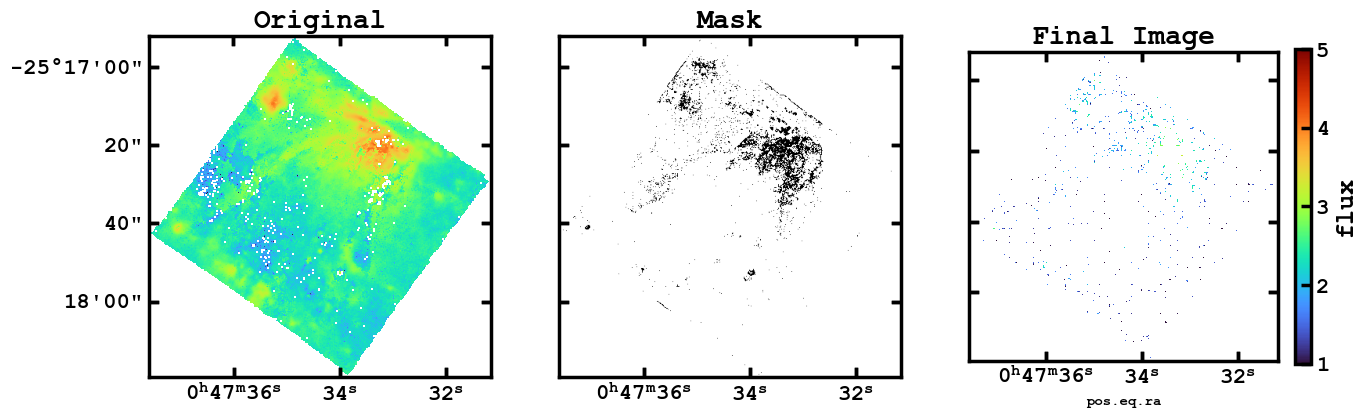

In [10]:
# smooth over siia and siib
from convolution import gauss_2d_kernel
from astropy.convolution import convolve, interpolate_replace_nans
kern = gauss_2d_kernel(sigma=0.5)

fig = plt.figure(figsize=(15,10))

ax = plt.subplot(1, 3, 1, projection=w)
ax.imshow(np.log10(siia_flux_disk), vmin=1, vmax=5, origin='lower', cmap='turbo')
ax.set_title('Original', fontsize=20)
ax.tick_params(axis='both', which='both',direction='in',
               width=2.5, labelsize=16, length=7)
ax.coords[0].set_auto_axislabel(False)
ax.coords[1].set_auto_axislabel(False)

# convolve with the original map; this will find pixels that deviate
# a lot from their neighbors
siia_flux_disk_conv = convolve(siia_flux_disk, kern, normalize_kernel=False, nan_treatment='fill')

# set a threshold: we want to find pixels that deviate by +/- 100
# blank out these pixels; this is our mask!
mask = np.abs(siia_flux_disk_conv) < 100
copy_siia_flux_disk = siia_flux_disk.copy()
copy_siia_flux_disk[~mask] = np.nan

ax = plt.subplot(1, 3, 2, projection=w)
im = ax.imshow(mask, origin='lower', cmap='Greys_r')
ax.set_title('Mask', fontsize=20)
ax.tick_params(axis='both', which='both',direction='in',
               width=2.5, labelsize=16, length=7)
ax.coords[0].set_auto_axislabel(False)
ax.coords[1].set_auto_axislabel(False)
ax.coords[1].set_ticklabel_visible(False)

# fill
fill_kern = gauss_2d_kernel(sigma=1)
final_siia_flux_disk = convolve(copy_siia_flux_disk, fill_kern, normalize_kernel=False, nan_treatment='fill')

ax = plt.subplot(1, 3, 3, projection=w)
final_siia_flux_disk[np.isnan(og_data[1])] = np.nan # [0] has some nans within
im = ax.imshow(np.log10(final_siia_flux_disk), vmin=1, vmax=5, origin='lower',cmap='turbo')
ax.set_title('Final Image',fontsize=20)
ax.tick_params(axis='both', which='both',direction='in',
                width=2.5, labelsize=16, length=7)
ax.coords[1].set_auto_axislabel(False)
ax.coords[1].set_ticklabel_visible(False)
bar = plt.colorbar(im, fraction=0.046)
bar.set_label('flux', fontsize=18)
bar.ax.tick_params(width=2.5, labelsize=16, length=7, direction='in')


# siia_disk_flux_smooth = convolve(siia_flux_disk, kern, normalize_kernel=False, nan_treatment='fill')
# plt.imshow(siia_disk_flux_smooth, origin='lower', vmax=1000, vmin=100)

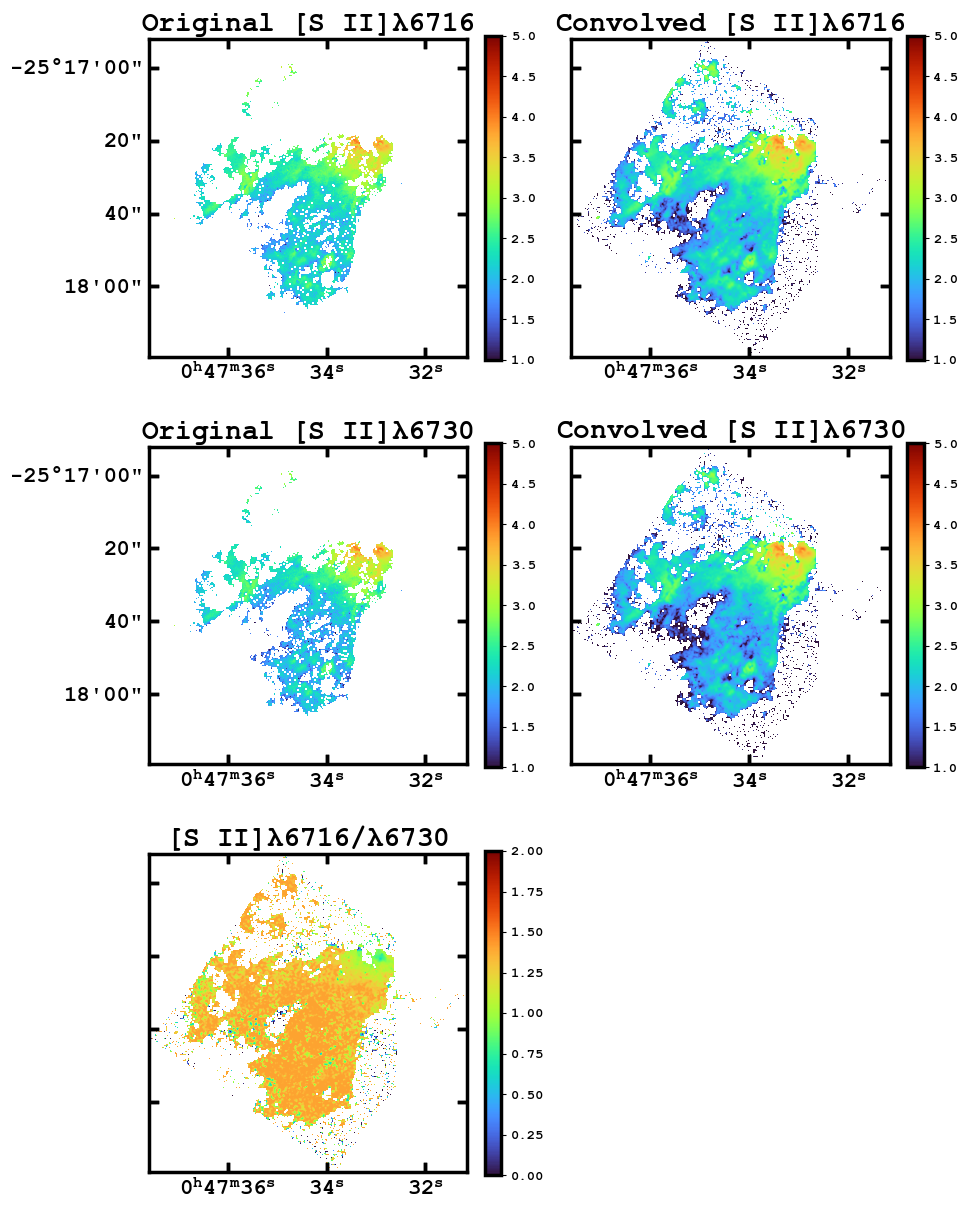

In [16]:
# width = number of pixels in each direction
kern = Box2DKernel(width=3)

from astropy.convolution import convolve, Box2DKernel

fig = plt.figure(figsize=(10,15))

ax = plt.subplot(3, 2, 1, projection=w)
im = ax.imshow(np.log10(siia_flux_outb), vmin=1, vmax=5, origin='lower', cmap='turbo')
ax.set_title('Original [S II]$\lambda$6716', fontsize=20)
ax.tick_params(axis='both', which='both',direction='in',
               width=2.5, labelsize=16, length=7)
ax.coords[0].set_auto_axislabel(False)
ax.coords[1].set_auto_axislabel(False)
bar = plt.colorbar(im, fraction=0.046)

siia_flux_outb_box = convolve(siia_flux_outb, kern, normalize_kernel=False, nan_treatment='fill')
# siia_flux_outb_box[~np.isfinite(siia_flux_outb)] = np.nan

ax = plt.subplot(3, 2, 2, projection=w)
ax.set_title('Convolved [S II]$\lambda$6716', fontsize=20)
im = ax.imshow(np.log10(siia_flux_outb_box), vmin=1, vmax=5, origin='lower', cmap='turbo')
ax.tick_params(axis='both', which='both',direction='in',
               width=2.5, labelsize=16, length=7)
ax.coords[0].set_auto_axislabel(False)
ax.coords[1].set_auto_axislabel(False)
ax.coords[1].set_ticklabel_visible(False)
bar = plt.colorbar(im, fraction=0.046)

# ===================================================================================================
ax = plt.subplot(3, 2, 3, projection=w)
im = ax.imshow(np.log10(siib_flux_outb), vmin=1, vmax=5, origin='lower', cmap='turbo')
ax.set_title('Original [S II]$\lambda$6730', fontsize=20)
ax.tick_params(axis='both', which='both',direction='in',
               width=2.5, labelsize=16, length=7)
ax.coords[0].set_auto_axislabel(False)
ax.coords[1].set_auto_axislabel(False)
bar = plt.colorbar(im, fraction=0.046)

siib_flux_outb_box = convolve(siib_flux_outb, kern, normalize_kernel=False, nan_treatment='fill')
# siib_flux_outb_box[~np.isfinite(siib_flux_outb)] = np.nan

ax = plt.subplot(3, 2, 4, projection=w)
ax.set_title('Convolved [S II]$\lambda$6730', fontsize=20)
im = ax.imshow(np.log10(siib_flux_outb_box), vmin=1, vmax=5, origin='lower', cmap='turbo')
ax.tick_params(axis='both', which='both',direction='in',
               width=2.5, labelsize=16, length=7)
ax.coords[0].set_auto_axislabel(False)
ax.coords[1].set_auto_axislabel(False)
ax.coords[1].set_ticklabel_visible(False)
bar = plt.colorbar(im, fraction=0.046)

# ===================================================================================================
test = siia_flux_outb_box / siib_flux_outb_box
test[test > 1.4] = 1.4

ax = plt.subplot(3, 2, 5, projection=w)
ax.set_title('[S II]$\lambda$6716/$\lambda$6730', fontsize=20)
im = ax.imshow(test, vmin=0, vmax=2, origin='lower', cmap='turbo')
ax.tick_params(axis='both', which='both',direction='in',
               width=2.5, labelsize=16, length=7)
ax.coords[0].set_auto_axislabel(False)
ax.coords[1].set_auto_axislabel(False)
ax.coords[1].set_ticklabel_visible(False)
bar = plt.colorbar(im, fraction=0.046)



np.savetxt('../../ngc253/muse/data/sii_outb_flux_rat_smooth.txt', siia_flux_outb_box / siib_flux_outb_box)

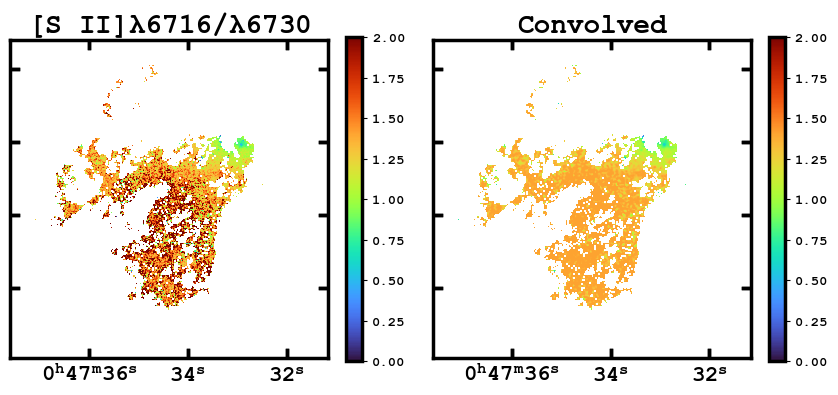

In [106]:
kern = Box2DKernel(width=3)

from astropy.convolution import convolve, Box2DKernel

fig = plt.figure(figsize=(10,15))


# ===================================================================================================
outb_test = convolve(siia_flux_outb / siib_flux_outb, kern, normalize_kernel=False, nan_treatment='fill')
outb_test[outb_test > 1.4] = 1.4
outb_test[~np.isfinite(siia_flux_outb / siib_flux_outb)] = np.nan

ax = plt.subplot(1, 2, 1, projection=w)
ax.set_title('[S II]$\lambda$6716/$\lambda$6730', fontsize=20)
im = ax.imshow(siia_flux_outb / siib_flux_outb, vmin=0, vmax=2, origin='lower', cmap='turbo')
ax.tick_params(axis='both', which='both',direction='in',
               width=2.5, labelsize=16, length=7)
ax.coords[0].set_auto_axislabel(False)
ax.coords[1].set_auto_axislabel(False)
ax.coords[1].set_ticklabel_visible(False)
bar = plt.colorbar(im, fraction=0.046)


ax = plt.subplot(1, 2, 2, projection=w)
ax.set_title('Convolved', fontsize=20)
im = ax.imshow(outb_test, vmin=0, vmax=2, origin='lower', cmap='turbo')
ax.tick_params(axis='both', which='both',direction='in',
               width=2.5, labelsize=16, length=7)
ax.coords[0].set_auto_axislabel(False)
ax.coords[1].set_auto_axislabel(False)
ax.coords[1].set_ticklabel_visible(False)
bar = plt.colorbar(im, fraction=0.046)


# np.savetxt('../../ngc253/muse/data/sii_outb_flux_rat_smooth.txt', siia_flux_outb_box / siib_flux_outb_box)

In [21]:
kern = Box2DKernel(width=3)
siia_flux_outb_box = convolve(siia_flux_outb, kern, normalize_kernel=False, nan_treatment='fill')
siib_flux_outb_box = convolve(siib_flux_outb, kern, normalize_kernel=False, nan_treatment='fill')

siia_flux_outr_box = convolve(siia_flux_outr, kern, normalize_kernel=False, nan_treatment='fill')
siib_flux_outr_box = convolve(siib_flux_outr, kern, normalize_kernel=False, nan_treatment='fill')

siia_flux_disk_box = convolve(siia_flux_disk, kern, normalize_kernel=False, nan_treatment='fill')
siib_flux_disk_box = convolve(siib_flux_disk, kern, normalize_kernel=False, nan_treatment='fill')

np.savetxt('../../ngc253/muse/data/sii_outb_flux_rat_smooth.txt', siia_flux_outb_box/siib_flux_outb_box)
np.savetxt('../../ngc253/muse/data/sii_outr_flux_rat_smooth.txt', siia_flux_outr_box/siib_flux_outr_box)
np.savetxt('../../ngc253/muse/data/sii_disk_flux_rat_smooth.txt', siia_flux_disk_box/siib_flux_disk_box)

In [22]:
# ================================================================
# SII ratio ratio, errors, then calculate S/N (N = errors)
# ================================================================

# the amp errors should be the same for all lines
# since they are calculated based on rms, sigma, and channel width
err_outb_infile = '../../ngc253/muse/data/output_maps/ngc253_muse_se_niib_amperr_outflow_blue.fits'
hdu_err_outb = fits.open(err_outb_infile)
amp_err_outb = hdu_err_outb[0].data

err_outr_infile = '../../ngc253/muse/data/output_maps/ngc253_muse_se_niib_amperr_outflow_red.fits'
hdu_err_outr = fits.open(err_outr_infile)
amp_err_outr = hdu_err_outr[0].data

err_disk_infile = '../../ngc253/muse/data/output_maps/ngc253_muse_se_niib_amperr_disk.fits'
hdu_err_disk = fits.open(err_disk_infile)
amp_err_disk = hdu_err_disk[0].data

# propagate the errors
# SII_tot error = sqrt(err^2 + err^2) = err*sqrt(2)
ERR_sii_disk = np.sqrt((amp_err_disk / siia_flux_disk_box)**2 + (amp_err_disk / siib_flux_disk_box)**2)
ERR_sii_outb = np.sqrt((amp_err_outb / siia_flux_outb_box)**2 + (amp_err_outb / siib_flux_outb_box)**2)
ERR_sii_outr = np.sqrt((amp_err_outr / siia_flux_outr_box)**2 + (amp_err_outb / siib_flux_outr_box)**2)

# now calculate the signal to noise
smooth_rats_outb = np.loadtxt('../../ngc253/muse/data/sii_outb_flux_rat_smooth.txt')
smooth_rats_outr = np.loadtxt('../../ngc253/muse/data/sii_outr_flux_rat_smooth.txt')
smooth_rats_disk = np.loadtxt('../../ngc253/muse/data/sii_disk_flux_rat_smooth.txt')

SNR_sii_disk_rat = smooth_rats_disk / ERR_sii_disk
SNR_sii_outb_rat = smooth_rats_outb / ERR_sii_outb
SNR_sii_outr_rat = smooth_rats_outr / ERR_sii_outr

# make an alpha layer for the signal to noise
alpha_SNR_sii_disk_rat = np.zeros_like(SNR_sii_disk_rat)
alpha_SNR_sii_disk_rat[SNR_sii_disk_rat < 3.] = 1.
alpha_SNR_sii_outb_rat = np.zeros_like(SNR_sii_outb_rat)
alpha_SNR_sii_outb_rat[SNR_sii_outb_rat < 3.] = 1.
alpha_SNR_sii_outr_rat = np.zeros_like(SNR_sii_outr_rat)
alpha_SNR_sii_outr_rat[SNR_sii_outr_rat < 3.] = 1.

In [23]:
edens_outb_5000 = np.loadtxt('../../ngc253/muse/data/edens_outb_5000.txt')
edens_outb_6000 = np.loadtxt('../../ngc253/muse/data/edens_outb_6000.txt')
edens_outb_8000 = np.loadtxt('../../ngc253/muse/data/edens_outb_8000.txt')
edens_outb_10e4 = np.loadtxt('../../ngc253/muse/data/edens_outb.txt')

np.mean(np.isfinite(edens_outb_5000)) / np.mean(np.isfinite(edens_outb_8000))

1.0188094047023513

In [24]:
def edens_osterbrock(ne_1e4, T):
    
    return ne_1e4 / ((10**4 / T)**(1/2))

yes
yes


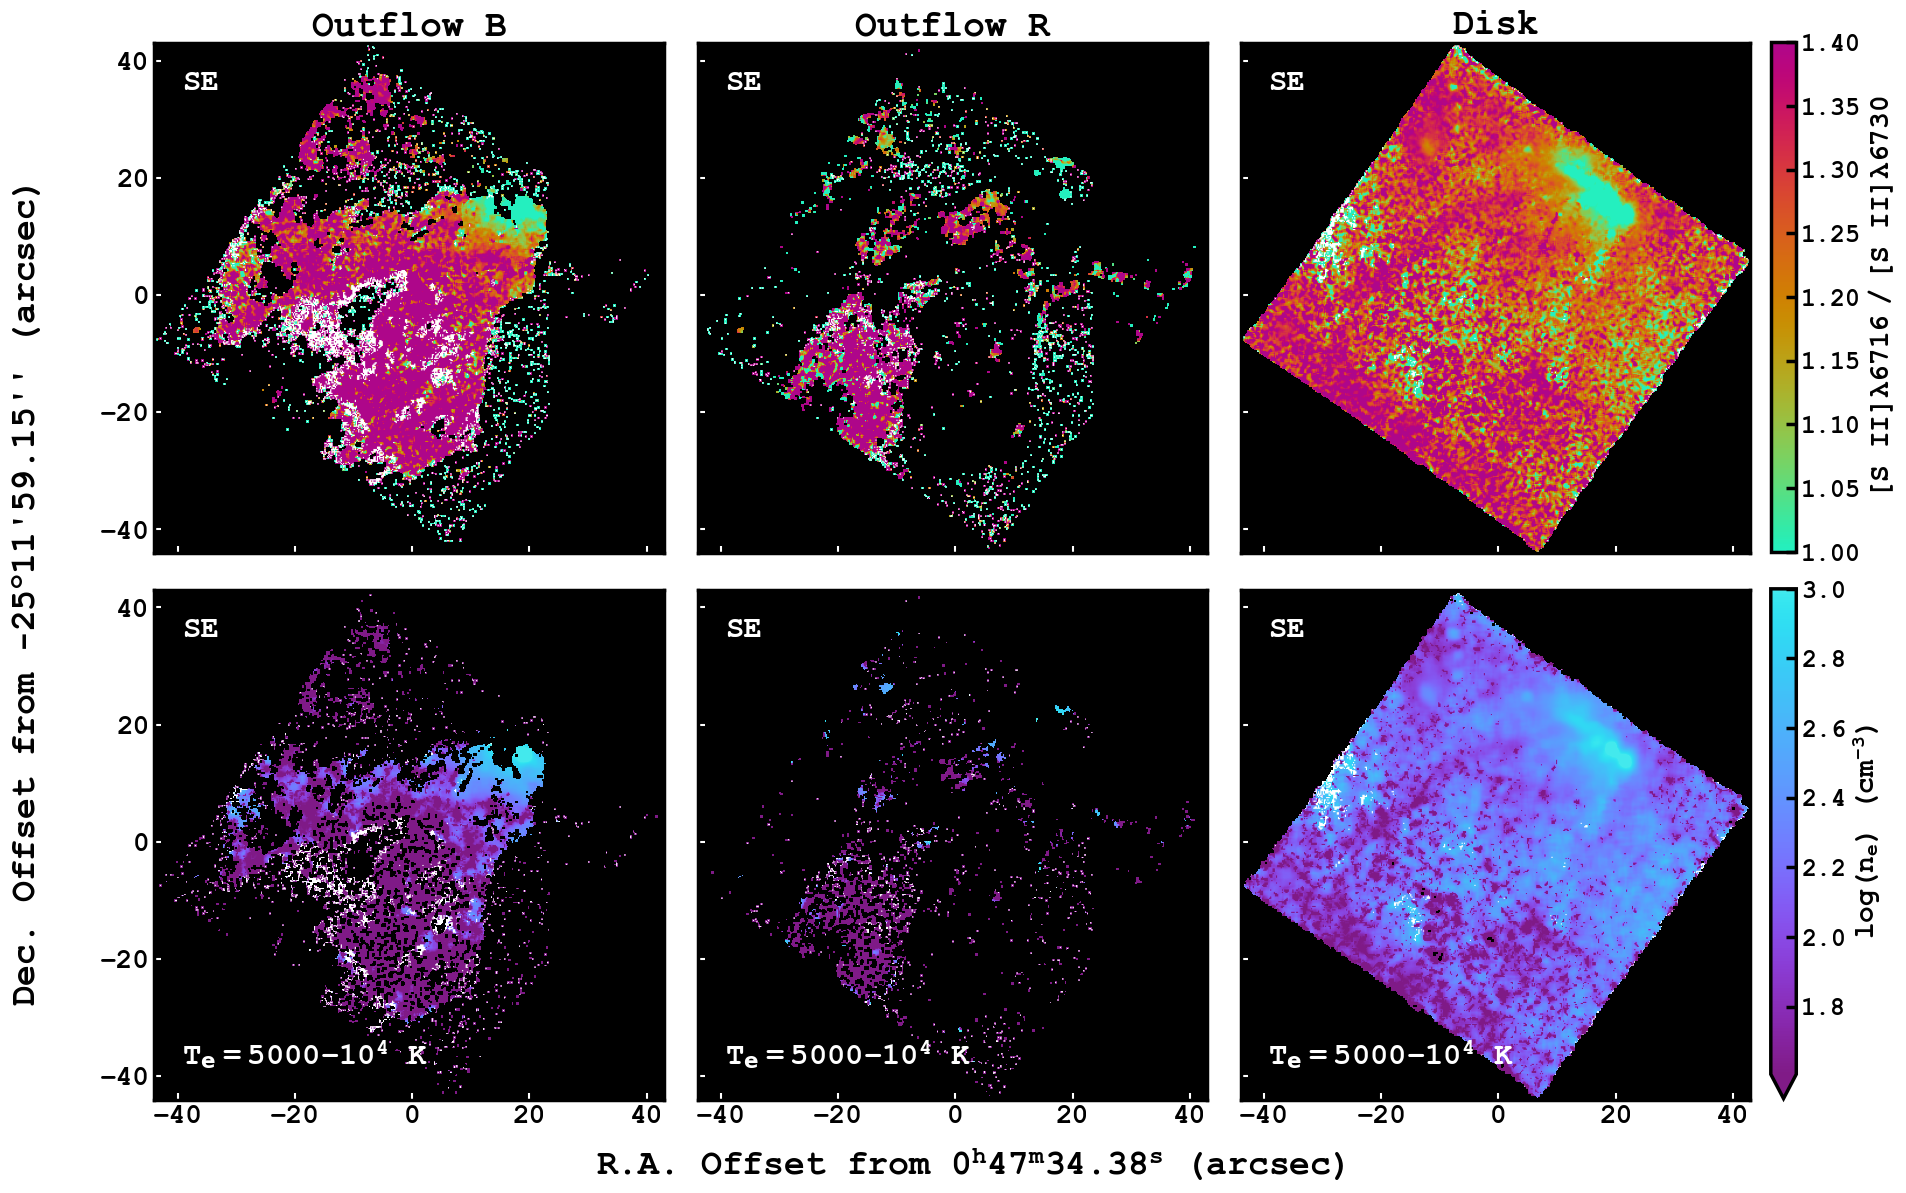

In [33]:
edens_outb = np.loadtxt('../../ngc253/muse/data/edens_outb_6500_smooth.txt')
edens_outr = np.loadtxt('../../ngc253/muse/data/edens_outr_6500_smooth.txt')
edens_disk = np.loadtxt('../../ngc253/muse/data/edens_disk_6500_smooth.txt')

edens_outb[smooth_rats_outb > 1.4] = edens_osterbrock(50, 6500)
edens_outr[smooth_rats_outr > 1.4] = edens_osterbrock(50, 6500)
edens_disk[smooth_rats_disk > 1.4] = edens_osterbrock(50, 6500)

vmin_edens = np.log10(edens_osterbrock(50, 6500))

fig, ((ax1, ax2, ax3),
     (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20, 12), sharex=True, sharey=True)

# top row
cmap = cmr.get_sub_cmap('cmr.tropical_r', 0.1, 0.90)
make_big_plot([ax1, ax2, ax3],
              smooth_rats_outb,
              smooth_rats_outr,
              smooth_rats_disk,
              vmin = 1.0,
              vmax = 1.4,
              titles = True,
              line_label = None,
              cbar_label = '[S II]$\lambda6716~/~$[S II]$\lambda6730$',
              extent=extent,
              cmap = cmap,
              cmap_extend = 'neither',
              alpha_outb = alpha_SNR_sii_outb_rat,
              alpha_outr = alpha_SNR_sii_outr_rat,
              alpha_disk = alpha_SNR_sii_disk_rat)

# cmap = cmr.get_sub_cmap('cmr.cosmic_r', 0.3, 1)
cmap = cmr.get_sub_cmap('cmr.gem', 0.3, 1)
# cmap.set_under('yellow')

make_big_plot([ax4, ax5, ax6],
              np.log10(edens_outb),
              np.log10(edens_outr),
              np.log10(edens_disk),
              vmin_edens,
              vmax = 3,
              titles = False,
              line_label = r'T$_{\rm e} = 5000{-}10^{4}$ K',
              cbar_label = 'log(n$_{e}$) (cm$^{-3}$)',
              extent = extent,
              cmap = cmap,
              cmap_extend = 'min',
              alpha_outb = alpha_SNR_sii_outb_rat,
              alpha_outr = alpha_SNR_sii_outr_rat,
              alpha_disk = alpha_SNR_sii_disk_rat)


fig.supxlabel('R.A. Offset from %s (arcsec)' % ra_hms, fontsize=25, family='courier new', weight='bold', style='normal')
fig.supylabel('Dec. Offset from %s (arcsec)' % dec_dms, fontsize=25, family='courier new', weight='bold', style='normal')
plt.tight_layout()
plt.subplots_adjust(wspace=-0.2)

# plt.savefig('../../ngc253/muse/visuals/edensity_pyneb_osterbrock.png',bbox_inches='tight', dpi=200)
# plt.savefig('../../ngc253/muse/visuals/edensity_pyneb_osterbrock.pdf',bbox_inches='tight', dpi=200)
plt.show()